# Prepare conservative interpolation for abukill;

some tests to improve mass conservations in experiments with adaptive mesh;

What we would need to transfer would be:    
- Constant inverted parameters (friction coeff. and viscosity) from a mesh where the inversion has been performed (see Elmer2Elmer notebook)
- Forcings and data (bed elevation) from external grids (see e.g. BedMachineToElmer notebook)
- diagnostic variables (velocity) to speed-up the first solution
- The prognostic variable from elmer (mainly ice thicknes);

As the idea is to re-initailise the bed from the data, I assume that it would be smoother to interpolate zs then re-compute the ice thickness (and zb) from the flotation; jsut prepare scripts to do it.



In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xugrid as xu
import xarray as xr
import numpy as np
import os
import sys

%matplotlib inline

In [2]:
sys.path.insert(0, os.path.abspath('../'))

from ElmerUgrid import ugrid
from ElmerUgrid.Interpolation import *
from ElmerUgrid.fem import TriIntegrate

In [3]:
rhow=1028.0
rhoi=917.0
Hmin=1.0

## Interpolation zs for abukill

In [4]:
# Load source file; the final step for abuk1b; first main adaptation loop.
tmp=xu.open_dataset("../DATA/result_abuk1b_1_5_5.nc",decode_times=False)
tmp.ugrid.set_crs("EPSG:4326")
proj=tmp.ugrid.to_crs("EPSG:3031")

## get th elast time step
source=proj.isel(time=-1)
source_grid=source.grid
## 
print(list(source.keys()))

['mesh2D_edge_x', 'mesh2D_edge_y', 'time_instant_bounds', 'time_bounds', 'cell_area', 'ceff', 'x', 'passive', 'y', 'ssavelocity 1', 'ssavelocity 2', 'vnorm', 'h', 'zs', 'zb', 'haf', 'bedrock', 'groundedmask', 'beta_1', 'mueta2', 'smb', 'mt 1', 'mt 2', 'mt 3', 'm1m2 1', 'm1m2 2', 'regionlabels_tag', 'regionlabels_noe', 'regionlabels_area', 'm1m2 3']


In [5]:
# Load the target; the initial step for abuk1b; second loop
tmp=xu.open_dataset("../DATA/result_abuk1b_2_5_0.nc",decode_times=False)
tmp.ugrid.set_crs("EPSG:4326")
proj=tmp.ugrid.to_crs("EPSG:3031")
## there is only one ts in the target but still take only the firts
target=proj.isel(time=0)
target_grid=target.grid

## Interpolation from the active set to the target mesh

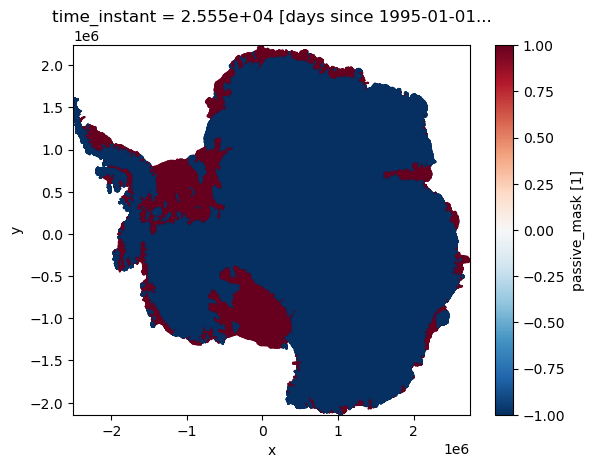

In [6]:
# Plot passive/active mask from the source;
# passive > 0 means that the element was passive in the simulation
passive=source.passive
passive.ugrid.plot()
#passive.ugrid.plot.line(color="white",linewidth=0.1)

nmesh2D_face
271984


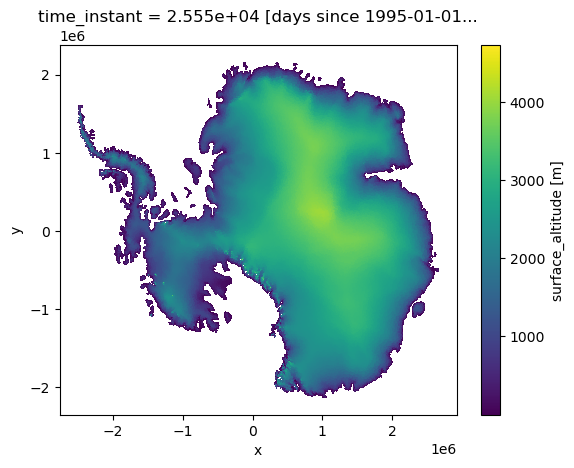

In [7]:
## select only the active set;
#### check the name of the face dimension
print(source_grid.face_dimension)
active_set=source.isel(nmesh2D_face=(source.passive.values < 0))
#active_set.zs.ugrid.plot()
print(active_set.grid.n_node)
active_set.zs.ugrid.plot()


### conservative interpolation

#### First check conservative interpolation of H

In [8]:
h_i=node_2_node_interpolation(source.h,target_grid,Bounded=True)

nans=np.count_nonzero(np.isnan(h_i.values))
if (nans > 0):
    print("there is %i nans in the output")

/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:339: RuntimeWarning: invalid value encountered in divide
  target_val=np.where(area_ratio > area_threshold,target_val/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:344: RuntimeWarning: invalid value encountered in divide
  target_grad[:,0] = np.where(area_ratio > area_threshold,target_grad[:,0]/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:345: RuntimeWarning: invalid value encountered in divide
  target_grad[:,1] = np.where(area_ratio > area_threshold,target_grad[:,1]/intersect_area,np.nan)


In [9]:
faces=cast_faces(target_grid.face_node_connectivity,target_grid.fill_value)
target_volume=TriIntegrate(values=h_i.values,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)

## in the target the bed has been re-interpolated from bedMachine; and thickness not been corrected to insure h>Hmin!!!
## but still check the volume
elmer_volume=TriIntegrate(values=target.h.values,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)

faces=cast_faces(source_grid.face_node_connectivity,source_grid.fill_value)
source_volume=TriIntegrate(values=source.h.values,
                  faces=faces,
                  nodes=source_grid.face_node_coordinates)

## as the mesh boundaryies do not exactlty match there is a remaining small difference that is not exactly 0.
print("source volume: %e target volume:%e diff: %e"%(source_volume,target_volume,(target_volume-source_volume)))
print("elmer volume: %e diff: %e"%(elmer_volume,(elmer_volume-source_volume)))

source volume: 2.488124e+16 target volume:2.488124e+16 diff: 7.375656e+09
elmer volume: 2.487184e+16 diff: -9.393623e+12


#### Interpolate bed

/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:339: RuntimeWarning: invalid value encountered in divide
  target_val=np.where(area_ratio > area_threshold,target_val/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:344: RuntimeWarning: invalid value encountered in divide
  target_grad[:,0] = np.where(area_ratio > area_threshold,target_grad[:,0]/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:345: RuntimeWarning: invalid value encountered in divide
  target_grad[:,1] = np.where(area_ratio > area_threshold,target_grad[:,1]/intersect_area,np.nan)


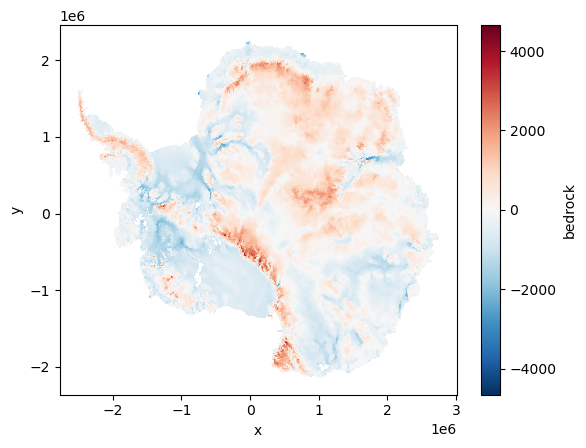

In [10]:
bed_i=node_2_node_interpolation(source.bedrock,target_grid,Bounded=True)

nans=np.count_nonzero(np.isnan(bed_i.values))
if (nans > 0):
    print("there is %i nans in the output")

bed_i.ugrid.plot()

<xarray.DataArray 'bed' (mesh2d_nFaces: 11108889)> Size: 44MB
array([-5917.82  , -5939.879 , -5956.5757, ..., -3580.3374, -3630.4927,
       -3660.5183], dtype=float32)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 89MB 0 1 2 ... 11108887 11108888


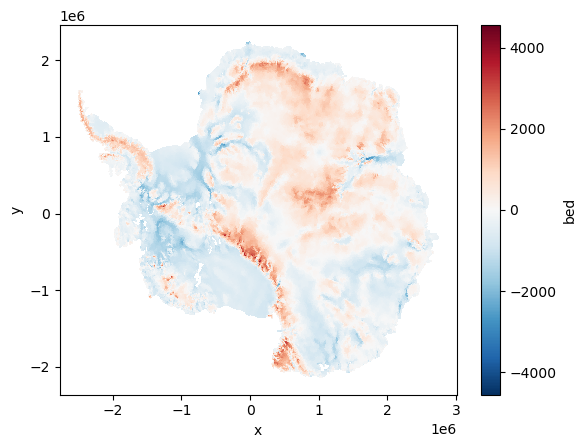

In [11]:
### The ioea will be to re-interpolate from bedmachine

bdm = xr.open_dataset("../DATA/BedMachineAntarctica_v02_m.nc")
## coarsen the data for faster testing
step=4
data=bdm.coarsen(x=step,y=step,boundary="trim").mean()
## will be better to save this result to avoid to recompute it each time...
data_ugrid=xu.UgridDataArray.from_structured(data.bed)
print(data_ugrid)
## assume that data are face_values
## results is a varaible defined on the elements
regridder = xu.OverlapRegridder(source=data_ugrid, target=target_grid, method="mean")
result_mean = regridder.regrid(data_ugrid)
#result_mean.ugrid.plot()

## project to nodes
face_values=result_mean.values
zero_values=np.zeros((target_grid.n_face,2))

result_n=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=target_grid.n_node,
                               faces=target_grid.face_node_connectivity,
                               facesx=target_grid.face_coordinates,
                               nodes=target_grid.face_node_coordinates
                               )

bed_bdm = xu.UgridDataArray(
            xr.DataArray(
                data=result_n,
                name="bed",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)

bed_bdm.ugrid.plot()

## Interpolate the surface now

/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:339: RuntimeWarning: invalid value encountered in divide
  target_val=np.where(area_ratio > area_threshold,target_val/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:344: RuntimeWarning: invalid value encountered in divide
  target_grad[:,0] = np.where(area_ratio > area_threshold,target_grad[:,0]/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Interpolation.py:345: RuntimeWarning: invalid value encountered in divide
  target_grad[:,1] = np.where(area_ratio > area_threshold,target_grad[:,1]/intersect_area,np.nan)
/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Projection.py:107: RuntimeWarning: invalid value encountered in divide
  result = np.where(weight > 0.0,output / weight,np.nan)


there is 46052 nans in the output
min max values: 0.107977 4661.357206


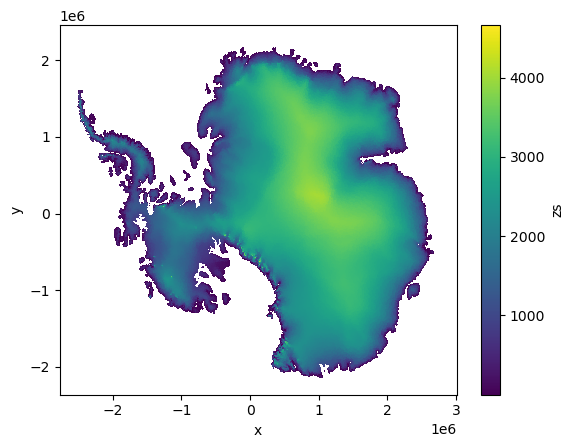

In [12]:
### interpolate only from the active set
zs_i=node_2_node_interpolation(active_set.zs,target_grid,Bounded=True)
nans=np.count_nonzero(np.isnan(zs_i.values))
if (nans > 0):
    print("there is %i nans in the output"%nans)

print("min max values: %f %f"%(np.nanmin(zs_i.values),np.nanmax(zs_i.values)))
zs_i.ugrid.plot()


In [13]:
## or from the whole data-set... this will introduce some smoothing at the passsive/active interface...
zs_i2=node_2_node_interpolation(source.zs,target_grid,Bounded=True)
nans=np.count_nonzero(np.isnan(zs_i2.values))
if (nans > 0):
    print("there is %i nans in the output"%nans)

## interpolate zb
zb_i2=node_2_node_interpolation(source.zb,target_grid,Bounded=True)


## check the volume again
surface=zs_i2.values
bedrock=bed_i.values
bottom=surface/(1.0-rhow/rhoi)
zb=np.where(bottom < bedrock,bedrock,bottom)
thickness0=surface-zb

faces=cast_faces(target_grid.face_node_connectivity,target_grid.fill_value)
test_volume0=TriIntegrate(values=thickness0,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)

## interpolation does not preserve zs>bedrock!!!
## I assume that the diffreence in the volumes is because applying the flotation makes the process not conservative
## still difference is one order of magnitude lower than the elmer interpolation (but remind that the bedrock was re-interpolated from bedmachine)
print("h0 min: %e, max0:%e"%(thickness0.min(),thickness0.max()))
print("volumes from h:%e ;from zs and bedrock:%e ; diff: %e "%(target_volume,test_volume0,target_volume-test_volume0))


## do zs_i -zb_i
thickness=zs_i2.values-zb_i2.values

faces=cast_faces(target_grid.face_node_connectivity,target_grid.fill_value)
test_volume=TriIntegrate(values=thickness,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)

## int h should be = int zs - int zb; so should be conservative if everything is conservative:
## I assume difference is because of the non matching boundaries; but it is small
print("h min: %e, max:%e"%(thickness.min(),thickness.max()))
print("volumes from h:%e ;from zs and b:%e ; diff: %e "%(target_volume,test_volume,target_volume-test_volume))



h0 min: -2.122453e+02, max0:4.605763e+03
volumes from h:2.488124e+16 ;from zs and bedrock:2.488030e+16 ; diff: 9.387086e+11 
h min: -7.700131e+01, max:4.605763e+03
volumes from h:2.488124e+16 ;from zs and b:2.488124e+16 ; diff: -1.626468e+06 


### Apply a correction for Hmin

In [14]:

## floattation; assume z_sealevel=0.
surface=zs_i.values
bedrock=bed_i.values
Hfloat=(0.0-bedrock)*rhow/rhoi
zsfloat=Hfloat*(1.0-rhoi/rhow)

##
H0=np.where(surface>zsfloat,surface-bedrock,surface/(1.0-rhoi/rhow))

H_corr=np.where(np.isfinite(H0) & (H0 > Hmin),H0,Hmin)
zs_corr=np.where(H_corr>Hfloat,bedrock+H_corr,H_corr*(1.0-rhoi/rhow))
zb_corr=zs_corr-H_corr

target_zs = xu.UgridDataArray(
            xr.DataArray(
                data=zs_corr,
                name="zs",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)
target_zb = xu.UgridDataArray(
            xr.DataArray(
                data=zb_corr,
                name="zb",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)

target_H = xu.UgridDataArray(
            xr.DataArray(
                data=H_corr,
                name="h",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)

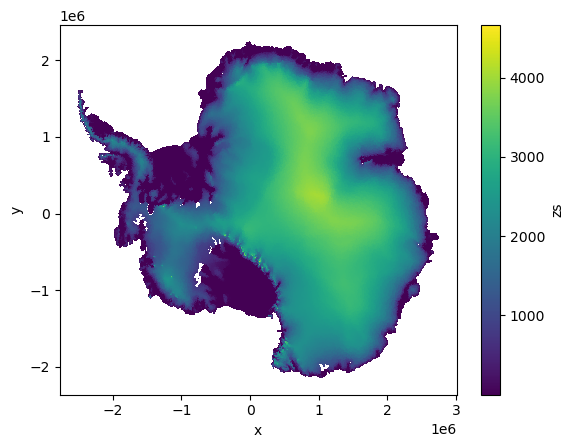

In [15]:
target_zs.ugrid.plot()

min max mean values: -3.863341e+02 4.849898e+02 1.272140e+00


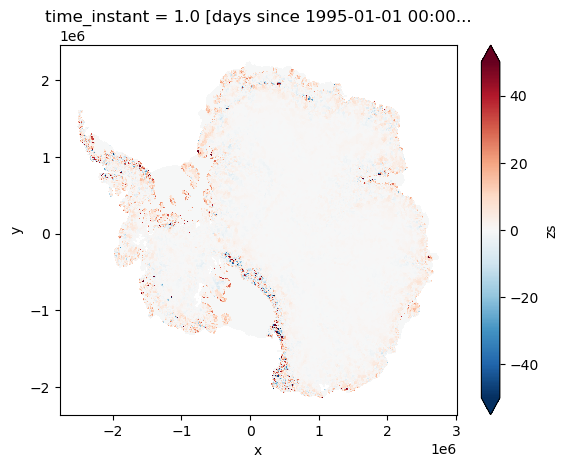

In [16]:
## Compare with zs that was in the target
dzs=target_zs-target.zs
dzs.ugrid.plot(vmin=-50.0, vmax=50.0, cmap='RdBu_r')

print("min max mean values: %e %e %e"%(dzs.values.min(),dzs.values.max(),dzs.values.mean()))
### zs is relatively smooth except in moutain ranges where the differences are the largest...

In [17]:
faces=cast_faces(target_grid.face_node_connectivity,target_grid.fill_value)
new_volume1=TriIntegrate(values=target_H.values,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)


print("source volume: %e target volume:%e diff: %e"%(source_volume,new_volume1,(new_volume1-source_volume)))

source volume: 2.488124e+16 target volume:2.491130e+16 diff: 3.006266e+13


#### test 2nd zs interpolation

In [18]:
## floattation; assume z_sealevel=0.

surface=zs_i2.values
bedrock=bed_i.values
Hfloat=(0.0-bedrock)*rhow/rhoi
zsfloat=Hfloat*(1.0-rhoi/rhow)

H0=np.where(surface>zsfloat,surface-bedrock,surface/(1.0-rhoi/rhow))

H_corr=np.where(np.isfinite(H0) & (H0 > Hmin),H0,Hmin)
zs_corr=np.where(H_corr>Hfloat,bedrock+H_corr,H_corr*(1.0-rhoi/rhow))
zb_corr=zs_corr-H_corr

target_zs2 = xu.UgridDataArray(
            xr.DataArray(
                data=zs_corr,
                name="zs",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)
target_zb2 = xu.UgridDataArray(
            xr.DataArray(
                data=zb_corr,
                name="zb",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)

target_H2 = xu.UgridDataArray(
            xr.DataArray(
                data=H_corr,
                name="h",
                dims=[target_grid.node_dimension],
                attrs=dict(mesh=target_grid.name,location="node")),target_grid)

min max mean values: -3.863341e+02 4.849898e+02 3.295562e-01


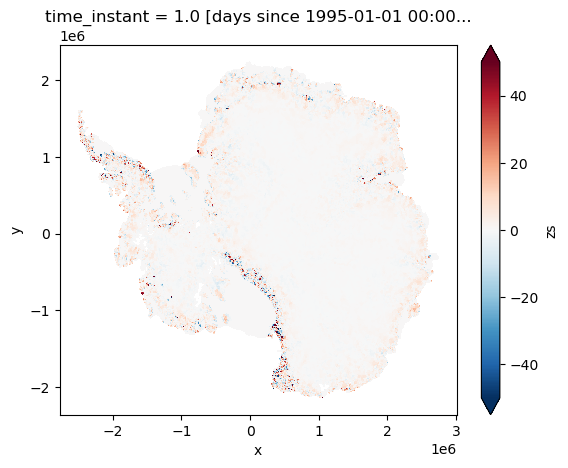

In [19]:
## Compare with zs that was in the target
dzs2=target_zs2-target.zs
dzs2.ugrid.plot(vmin=-50.0, vmax=50.0, cmap='RdBu_r')

print("min max mean values: %e %e %e"%(dzs2.values.min(),dzs2.values.max(),dzs2.values.mean()))

In [20]:
faces=cast_faces(target_grid.face_node_connectivity,target_grid.fill_value)
new_volume2=TriIntegrate(values=target_H2.values,
                  faces=faces,
                  nodes=target_grid.face_node_coordinates)

print("source volume: %e target volume:%e diff: %e"%(source_volume,new_volume2,(new_volume2-source_volume)))

source volume: 2.488124e+16 target volume:2.488053e+16 diff: -7.062113e+11


# Conclusion

- 2nd interpolation is more conservative; normal as in the first case there is more partial overlap. But here we compute the whole volume not only the vaf; which is the one who is going to matter at then end)
- Conservative interpolation does not conserve differences, i.e. zs>zb (because of the interpolation of the gradients?)
- Applying floation is not conservative.
- if we apply conservative interpolation for the bedrock from the begining we should remain more conservative...
